<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>


<center>
<h3 style="color:#888888;"> <i>--  Introduction à la méthode de Boltzmann sur Réseau  --</i> </h3>
<h1> TP n°3 </h1>
<h3> Ecoulement autour d'un cylindre Carré </h3>

<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

<h1> Préambule </h1>

Le TP doit être rendu sous la forme d'un Notebook jupyter en respectant la nomenclature suivante:
<center>
<b>TP3_NOM1_NOM2.ipynb</b>
</center>

Tous les résultats, discussions, analyses, doivent donc être inclus dans le fichier.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython import get_ipython
fs=20
plt.style.use('seaborn-dark')
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.rc('text', usetex=True)
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.usetex'] = False

<h1>Présentation du TP</h1>

On se propose dans se TP de simuler numériquement l'écoulement d'un fluide autour d'un cylindre carré à l'aide d'un code Lattice Boltzmann utilisant le modèle $D2Q9$.

<h2>Le modèle D2Q9</h2>

Le modèle à 9 vitesses de la méthode de Boltzmann sur réseau assure l'égalitité des moments jusqu'à l'ordre 2 et permet donc la simulation des écoulements visqueux régit par les équations de Navier-Stokes avec une limitation en nombre de Mach.
Les paramètres du modèle sont résumés dans le tableau suivant:

<table style="width:800px;text-align:center;">
<tr><td>$c_\alpha$</td><td>$\omega_\alpha$</td><td>$c_0$</td><td>$\tau_g$</td></tr>
<tr><td>$(0,0)\\ (1,0) (0,1) (-1,0) (0,-1)\\ (1,1) (-1,1) (-1,-1) (1,-1)$</td><td>$\dfrac{4}{9},\\ \dfrac{1}{9},\dfrac{1}{9},\dfrac{1}{9},\dfrac{1}{9},\\ \dfrac{1}{36},\dfrac{1}{36},\dfrac{1}{36},\dfrac{1}{36}$</td><td>$\dfrac{1}{\sqrt{3}}$</td><td width=30%>$\dfrac{1}{2}+\dfrac{\tilde{\nu}}{c_0^2}$</td></tr>
</table>

La fonction d'équilibre du modèle s'écrit:
$$
\displaystyle{g_{\alpha}^{eq}=\rho\omega_\alpha\left(1+\dfrac{c_{\alpha,i}u_i}{c_0^2}+\dfrac{(c_{\alpha,i}u_i)^2}{2c_0^4}-\dfrac{u_i^2}{2c_0^2}\right)}
$$

et son algorithme général:
$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha}-\dfrac{1}{\tau_g}[g_{\alpha}-g_{\alpha}^{eq}]\\
g_{\alpha}(x,y) = g_{\alpha}^{coll}(x-c_{\alpha,x},y-c_{\alpha,y})}
$$

Les variables macroscopiques sont calculées à partir des moments des fonctions de distribution:
$$
\rho=\sum_{\alpha=1}^9 g_{\alpha}
$$

$$
\rho u_x=\sum_{\alpha=1}^9 c_{\alpha,x}g_{\alpha}
$$

$$
\rho u_y=\sum_{\alpha=1}^9 c_{\alpha,y}g_{\alpha}
$$


<h2>Le cylindre carré</h2>

L'écoulement autour d'un cylindre carré est un cas test très utilisé en CFD et en particulier en Lattice Boltzmann car il présente l'avantage d'avoir une géométrie cartésienne simple. Le nombre de Reynolds de cet écoulement est basé sur le coté $D$ du carré:
$$
Re=\dfrac{U_0 D}{\nu}
$$

<center>
<img src="https://hpp.education/Lessons/LBM/ENSTA/SquareCylinder.png" style="width:650px;"/>
    <b><i>Figure 1: Géométrie du domaine de calcul</i></b>
</center>


Au delà d'une valeur critique $R_e=48$, l'écoulement devient instable et on observe une allée de von Karmann se former, caractérisée par des tourbillons en opposition de phase en aval du cylindre. Pour les faibles nombres de Reynolds ($Re<500$), on peut estimer la distance $\delta$ moyenne entre les tourbillons: $\delta\sim 2.5 D$

<h1>Travail demandé</h1>
<h2>Définition des paramètres et des fonctions</h2>

Pour les paramètres du calcul, on définira tous le domaine à partir du Rayon du cylindre carré $R$. On prendra un domaine $(L_x, L_y)=(40R,20R)$ de résolution $(n_x,n_y)$ mailles. On placera le cylindre à 8 rayons du bord gauche du domaine (input) et à égale distance des bors hauts et bas.

On souhaite réaliser plusieurs simulations en faisant varier le nombre de Reynolds et le type de conditions aux limites. Le nombre de Mach sera fixé à $M_0=0.3$.

<b style="color:#0055FA">1. Completer la cellule suivante à partir des données fournies et des définition du cours. On commencera par représenter le rayon du cylindre avec 5 mailles.</b>

In [ ]:
ca=np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]]) #shéma D2Q9 donc 9 directions
w=[4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] #racines des polynomes de Hermites (TP 0)
c0=1/np.sqrt(3) # facteur de normalisation des vitesses propres lorsque l'on conserve les moments jusqu'à l'ordre 2

# Maillage/Domaine

R=5 # rayon du cylindre

Lx=40*R # taille du domaine en fonction de R
Ly=20*R

nx=70*R # paramètre de maill, en fonction de R
ny=40*R

x0,y0=int(8*R),int(ny/2) # centre du cylindre

dx = R/nx # Taille de maille:

# Vitesse du son réelle à 293K:
c0_real=np.sqrt(1.4*287*293) #racine de gamma*R*T pour gaz parfaits

dt=dx*c0/c0_real # Pas de temps

M0=0.3 # Mach:

U0=M0*c0 # vitesse du fluide initiale
print(U0)

print('nb de mailles : '+str(nx*ny))

0.17320508075688776
nb de mailles : 70000


<b style="color:#0055FA">2. Compléter chacune des fonctions suivantes correspondant aux étapes de l'algorithme</b>
    
<b>Initialisation:</b> Définir la fonction permettant d'initialiser le domaine avec une densité uniforme $\rho=1$, et une vitesse uniforme $U_0$. Calculer également le paramètre de relaxation $\tau_g$ en fonction du nombre de Reynolds souhaité:

In [ ]:
def init(M0,Re):

    # Initialisation du domaine
    rho,uy=np.ones((nx,ny)),np.zeros((nx,ny))
    ux=U0*np.ones((nx,ny)) # le fluide est initalement à la vitesse U0 selon l'axe x
    # !!! Votre taug n'était pas bien calculé
    nu=U0*2*R/Re #augmenter Re veut dire diminuer la viscosité
    taug=0.5+3*nu # on se sert de la formule du cours
    print('Valeur de taug : '+str(taug)+' \n')

    # on doit mettre à l'équilibre la fonction geq car le fluide n'est pas au repos
    geq=np.zeros((nx,ny,9))
    geq=eq(rho,ux,uy,geq,c0,ca)
    return geq,rho,ux,uy,taug,U0,nu

<b>Equilibre:</b>  Dans ce TP nous avons besoin de calculer explicitement les fonctions de distribution à l'équilibre. Définir la fonction permettant la mise à jour de ces distributions en fonction des moments $\rho$, $u_x$ et $u_y$.

In [ ]:
def eq(rho,ux,uy,geq,c0,ca):
    # Mise à jour de geq
    for i in range (0,9):
        # ca[i,0] donne le vecteur vitesse associé selon les polynomes de Hermite
        # développement polynomial de la fonction d'équilibre pour une quadrature de guass à l'ordre 2
        geq[:,:,i] = rho[:,:]*w[i]*(1.+ (ca[i][0]*ux + ca[i][1]*uy) / (c0**2) + ( (  ca[i][0]*ux + ca[i][1]*uy )**2) / (2.*c0**4) - (ux**2 + uy**2) / (2.*c0**2) )
    return geq

<b>Collision:</b>  Ecrire simplement l'étape de collision:

In [ ]:
def collide(gcoll,g,geq,taug):
    # Etape de collision
    gcoll[:,:,:]=g[:,:,:]-1/taug*(g[:,:,:]-geq[:,:,:])
    return(gcoll)

<b>Propagation:</b> Pour cette étape on pourra utiliser du slicing plutôt qu'une boucle sur l'espace.

In [ ]:
def propagate(g,gcoll):

    # Etape de propagation, identique au TP précédent

    g[:,:,0]=gcoll[:,:,0] #[0,0]

    g[1:,:,1]=gcoll[0:-1,:,1] #[1,0]
    g[:,1:,2]=gcoll[:,0:-1,2] #[0,1]
    g[0:-1,:,3]=gcoll[1:,:,3]#[-1,0]
    g[:,0:-1,4]=gcoll[:,1:,4]#[0,-1]

    g[1:,1:,5]=gcoll[0:-1,0:-1,5]#[1,1]
    g[0:-1,1:,6]=gcoll[1:,0:-1,6]#[-1,1]
    g[0:-1,:-1,7]=gcoll[1:,1:,7]#[-1,-1]
    g[1:,0:-1,8]=gcoll[0:-1,1:,8]#[1,-1]

    return(g)


<b>Calcul des moments:</b> Calcul les variables macroscopiques $\rho$,$u_x$,$u_y$

In [ ]:
def macro(g,rho,ux,uy):

    # identique au TP précédent

    # calcul des variables macro
    rux,ruy,rho=np.zeros((nx,ny)),np.zeros((nx,ny)),np.zeros((nx,ny))
    for i in range (0,9):
        rho+=g[:,:,i]
        rux+=g[:,:,i]*ca[i,0]
        ruy+=g[:,:,i]*ca[i,1]
        #On est en quadrature d'ordre 3 pour la quadrature de Gauss, donc on a egalité des moments jusqu’à l’ordre 2 (modèle D2Q9)
    ux=rux/rho
    uy=ruy/rho
    # # remettre les Conditions de vitesse au bord superieur ??
    # ux[0,:]=U0
    # uy[0,:]=0

    return(rho,ux,uy)

<b>Condition aux limites solide:</b> Définir la fonction permettant de mettre à jour les distributions inconnues sur les parois solides. On distinguera dans ce TP la version avec frotement et la version sans frottement.

In [ ]:
def wall_slip(gcoll,g,mask):
    # Paroi solide sur le cylindre: Bounce back sans frottement
    g[mask==1,0]=gcoll[mask==1,0]
    g[mask==1,1]=gcoll[mask==1,3]
    g[mask==1,2]=gcoll[mask==1,4]
    g[mask==1,3]=gcoll[mask==1,1]
    g[mask==1,4]=gcoll[mask==1,2]
    g[mask==1,5]=gcoll[mask==1,6]
    g[mask==1,6]=gcoll[mask==1,5]
    g[mask==1,7]=gcoll[mask==1,8]
    g[mask==1,8]=gcoll[mask==1,7]
    return(g)

In [ ]:
def wall_noslip(gcoll,g,mask):
    # Paroi solide sur le cylindre: Bounce back avec frottement
    g[mask==1,0]=gcoll[mask==1,0]
    g[mask==1,1]=gcoll[mask==1,3]
    g[mask==1,2]=gcoll[mask==1,4]
    g[mask==1,3]=gcoll[mask==1,1]
    g[mask==1,4]=gcoll[mask==1,2]
    g[mask==1,5]=gcoll[mask==1,7]
    g[mask==1,6]=gcoll[mask==1,8]
    g[mask==1,7]=gcoll[mask==1,5]
    g[mask==1,8]=gcoll[mask==1,6]
    return(g)

<b>Condition aux limites fluide:</b> Définir la fonction permettant de mettre à jour les moments $u_x, \rho_{in}$ et les distributions inconnues à l'entrée du domaine. On utilisera les approches vues dans le cours pour le bounce-back hors équilibre (NEBB):

$$
g_?-g_?^{eq}=g_\overline{?}-g_\overline{?}^{eq}
$$

Ici $\overline{?}$ désigne la vitesse opposée à la vitesse $?$.

Exprimer la densité en entrée $\rho_{in}$ en fonction des distributions connues et de la vitesse $U_0$

___
$\rho_{in}=\frac{1}{1-u_x} \left(2(g_2+g_6+g_5) + g_1 + g_3\right)$



___

En identifiant les distributions inconnues en entrée, simplifier l'expression ci-dessus en fonction des moments connu sur le bord supérieur:

___
$g_?=...$

$g_?=...$

$g_?=...$
___




In [ ]:
def inflow(g,rho,ux,uy,M0,c0,ca,geq):

    # Conditions de vitesse au bord superieur
    ux[0,:]=M0/np.sqrt(3) # !! ici il faut utiliser le M0 que vous passez en entrée
    uy[0,:]=0

    # Macro: On impose ux et on en déduit rho_in:
    # !! Vous avez oublié le g[0] dans la somme
    rho[0,:]=1/(1-ux[0,:])*(2*(g[0,:,6]+g[0,:,3]+g[0,:,7])+g[0,:,0]+g[0,:,2]+g[0,:,4])

    # Distributions: On impose les distributions inconnues avec le Bounce-Back hors equilibre

    #recalcul des équilibres pour rho_wall
    '''
    g[0,:,5]=rho[0,:]*w[5]*(1+3*U0+(9/2*U0**2-(3/2)*(U0**2)))
    g[0,:,1]=rho[0,:]*w[1]*(1+3*U0+(9/2*U0**2-(3/2)*(U0**2)))
    g[0,:,8]=rho[0,:]*w[8]*(1+3*U0+(9/2*U0**2-(3/2)*(U0**2)))
    '''
    geq=eq(rho,ux,uy,geq,c0,ca) #recalcul des équilibres pour rho_inflow
    g[0,:,5]=g[0,:,7]+(geq[0,:,5]-geq[0,:,7])
    g[0,:,1]=g[0,:,3]+(geq[0,:,1]-geq[0,:,3])
    g[0,:,8]=g[0,:,6]+(geq[0,:,8]-geq[0,:,6])
    #g[0,:,5]=geq[0,:,5]
    #g[0,:,1]=geq[0,:,1]
    #g[0,:,8]=geq[0,:,8]

    return(g,geq,ux,uy,rho)

<b>Condition aux limites en sortie:</b> Pour les fonctions de distributions inconnues en sortie, on imposera une condition de gradient nul:

$$
\dfrac{\partial g_\alpha}{\partial x_n}=0
$$

Ou $x_n$ désigne ici la normale à la paroi concernée.

In [ ]:
def outflow(g,gcoll):
    # Conditions de gradient nul

    # Out
    g[-1,:,3]=gcoll[-2,:,3]
    g[-1,:,6]=gcoll[-2,:,6]
    g[-1,:,7]=gcoll[-2,:,7]
    # Top !! i=-1 et i-1=-2
    g[1:,-1,4]=gcoll[1:,-2,4]
    g[1:,-1,7]=gcoll[1:,-2,7]
    g[1:,-1,8]=gcoll[1:,-2,8]
    # Bottom !! pareil
    g[1:,0,2]=gcoll[1:,1,2]
    g[1:,0,5]=gcoll[1:,1,5]
    g[1:,0,6]=gcoll[1:,1,6]

    return(g)

<h2>Calcul</h2>

<b style="color:#0055FA">3. Une fois les paramètres et les fonctions définis, fixer le nombre de Reynolds (on commencera par $Re=20$), initialiser les distributions à leur valeur d'équilibre puis définir les mailles concernées par une condition aux limites solide.</b> Pour cela on pourra utiliser une variable de type *mask* de la même taille que le domaine et valant 0 pour une maille fluide et 1 pour une maille solide.

(0.0, 350.0, 0.0, 200.0)

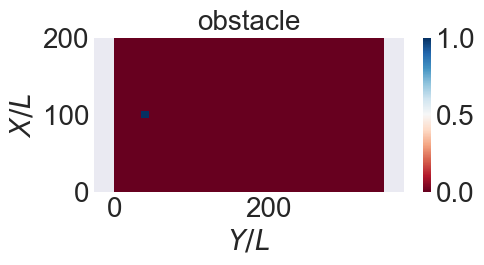

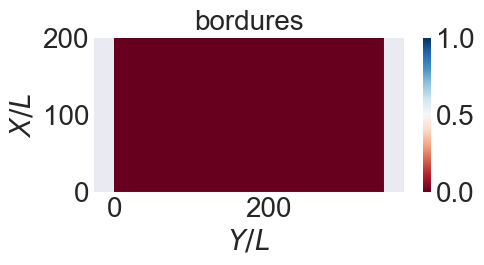

In [ ]:
# Marquage des conditions aux limites:
# Fluide: mask=0
# Solide: mask=1
# mask=-1 à l'intérieur du solide, on ne fait pas le calcul

mask=np.zeros((nx,ny));

# on vectorise la création de l'obstacle
def obstacle(mask,x0,y0,R):
    nx,ny=mask.shape
    mask[int(x0-R):int(x0+R),int(y0-R):int(y0+R)]=1

# on visualise les bordures et l'obstacle
mask_bordure=np.zeros((nx,ny));
mask_bordure[:,0]=1 # top
mask_bordure[:,-1]=1 # right
mask_bordure[-1,:]=1 # bottom

obstacle(mask,x0,y0,R)

fig=plt.figure(figsize=(5,2))

plt.pcolormesh(mask.T,cmap='RdBu')
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title(r'obstacle',fontsize=fs)
plt.axis('equal')

fig=plt.figure(figsize=(5,2))

plt.pcolormesh(mask_bordure.T,cmap='RdBu')
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title('bordures',fontsize=fs)
plt.axis('equal')

In [ ]:
# Nombre de Reynolds:
Re=300

# initialisation:
geq,rho,ux,uy,taug,U0,mu=init(M0,Re)
g,gcoll=geq.copy(),geq.copy()
nt=0
start=time.time()

nitération=2000 # nombre d'itération souhaité
skip=nitération-50 # permet d'afficher à partir d'un certain nombre de tours

while (nt<nitération):

    nt+=1

    # boucle de LBM
    gcoll=collide(gcoll,g,geq,taug) # étape de collision
    g=propagate(g,gcoll) # étape de propagation
    g=wall_noslip(g,g,mask) # condition limite de bord d'obstacle
    g=outflow(gcoll,g) # condition limite de sortie Neumann
    g,geq,ux,uy,rho=inflow(g,rho,ux,uy,M0,c0,ca,geq) # condition limite entrée
    rho,ux,uy=macro(g,rho,ux,uy) # calcul des grandeurs macro

    geq=eq(rho,ux,uy,geq,c0,ca)


tcal=time.time()-start
print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+str((1e-6)*nt*nx*ny/tcal)+"  MLUPS")

Valeur de taug : 0.5173205080756887 

2000 itérations en 149.65786147117615s: Performances: 0.9354670621627436  MLUPS


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


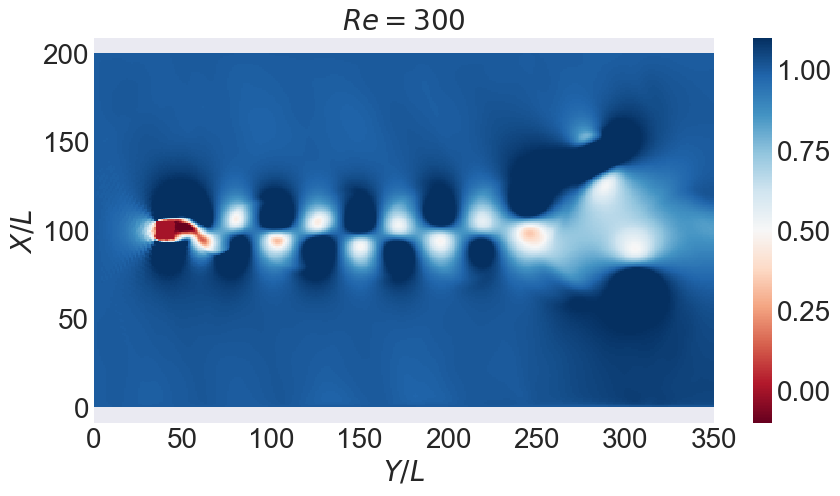

In [ ]:
fig=plt.figure(figsize=(10,5)) # on veut afficher uy pour vérifier l'écoulement
#plt.pcolormesh(ux.T,cmap='RdBu',vmin=-0.00001,vmax=0.00001)
plt.pcolormesh((ux.T)/U0,cmap='RdBu',vmin=-0.1,vmax=1.1)
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)
plt.axis('equal')
# on trouve bien de jolies alternance pour uy, qui explique la naissance des tourbillons
print(ux[0,:]/U0)

Text(0.5, 1.0, '$Re=300$')

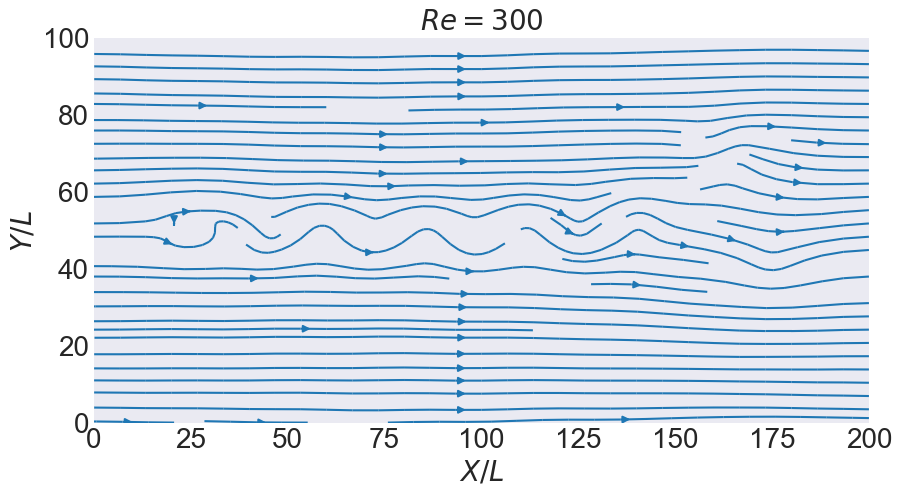

In [ ]:
fig=plt.figure(figsize=(10,5)) # on veut afficher le flot pour vérifier l'écoulement
x=np.linspace(0,Lx,nx)
y=np.linspace(0,Ly,ny)
plt.streamplot(x,y,(ux.T),uy.T)
plt.xlabel(r'$X/L$',fontsize=fs)
plt.ylabel(r'$Y/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)

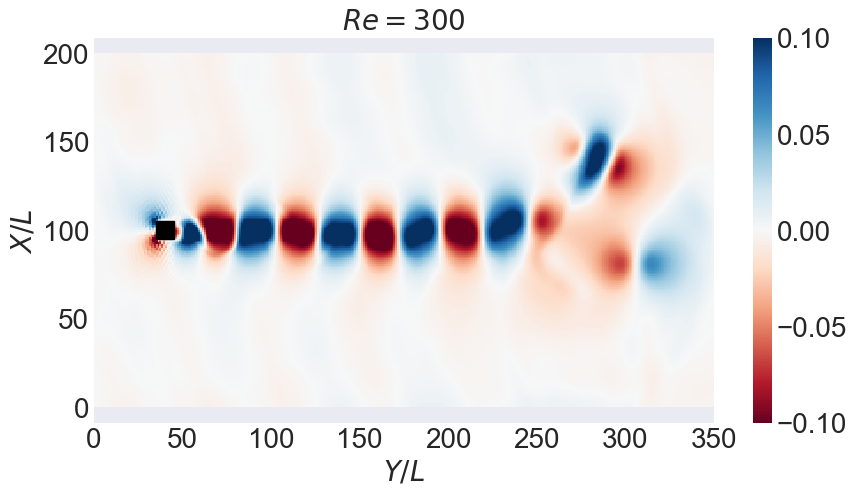

In [ ]:
fig=plt.figure(figsize=(10,5)) # on veut afficher uy pour vérifier l'écoulement
plt.pcolormesh(uy.T,cmap='RdBu',vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)
plt.axis('equal')
rect=patches.Rectangle((x0-R,y0-R),2*R,2*R, fill = True, color = "black",linewidth = 1)
plt.gca().add_patch(rect)
# on trouve bien de jolies alternance pour uy, qui explique la naissance des tourbillons

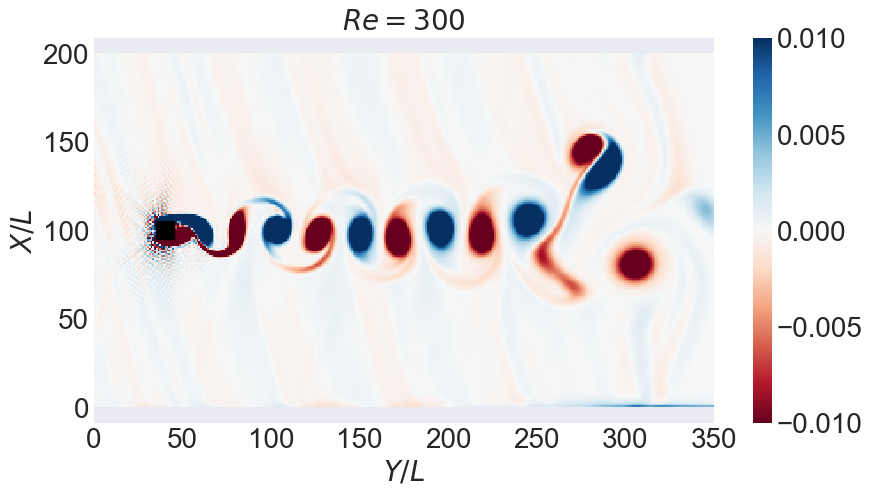

In [ ]:
dudx,dudy=np.gradient(ux,edge_order=2)
dvdx,dvdy=np.gradient(uy,edge_order=2)
vort=dudy-dvdx

fig=plt.figure(figsize=(10,5)) # on veut afficher uy pour vérifier l'écoulement
plt.pcolormesh(vort.T,cmap='RdBu',vmin=-0.01,vmax=0.01)
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)
plt.axis('equal')
rect=patches.Rectangle((x0-R,y0-R),2*R,2*R, fill = True, color = "black",linewidth = 1)
plt.gca().add_patch(rect)
# on trouve bien de jolies alternance pour uy, qui explique la naissance des tourbillons

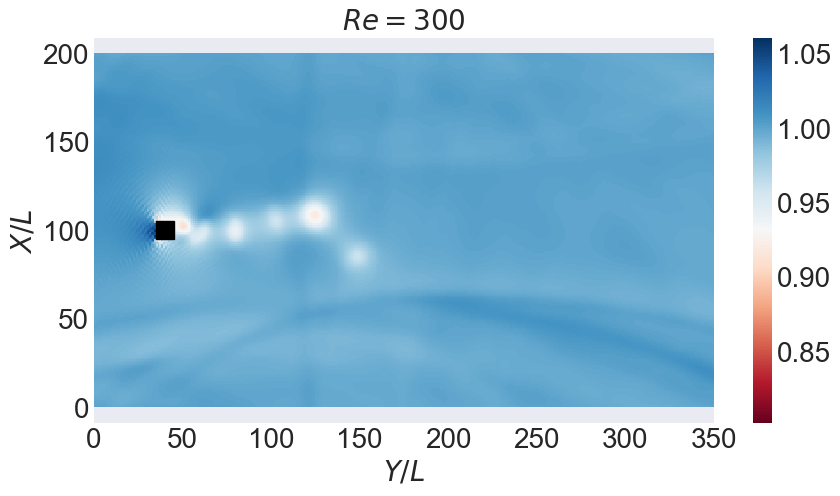

In [ ]:
fig=plt.figure(figsize=(10,5)) # on veut afficher uy pour vérifier l'écoulement
plt.pcolormesh(rho.T,cmap='RdBu')
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)
plt.axis('equal')
rect=patches.Rectangle((x0-R,y0-R),2*R,2*R, fill = True, color = "black",linewidth = 1)
plt.gca().add_patch(rect)
# on trouve bien de jolies alternance pour uy, qui explique la naissance des tourbillons

<b style="color:#0055FA">4. Definir une fonction permettant le calcul du coefficient de trainée du cylindre  $C_d$: </b>

La force de trainée s'exprime:

$$
F_d=\dfrac{1}{2}\rho U_0^2 S_{ref} C_d = \int_{wall}p dS_x
$$

Ou $dS_x$ est un élément de surface projeté sur l'axe x.

Montrer que l'on peut donc approximer dans le cas du carré:
$$
C_d \sim \dfrac{c_0^2}{p_{dyn} S_{ref}} \left(\sum_{w+}\rho - \sum_{w-}\rho  \right )
$$

Ou $w_+$ et $w_-$ représentent les 2 faces avant et arrière du cylindre.

In [ ]:
def dragcoeff(rho,mask,M0):
    c=0
    sum_plus=0
    sum_moins=0
    for j in np.arange(y0-R,y0+R+1):
        sum_moins+=rho[x0-R,j]
        sum_plus+=rho[x0+R,j]
    c = 1 / ( 2*R**2*(M0**2) ) * ( sum_plus - sum_moins )
    return c

<b style="color:#0055FA">Commentaire : </b> Rho en amont vaut 1. La pression dynamique peut donc s'écrire comme 0.5*U0^2.
Sref est le maitre couple du cube, qui vaut 4*R*R. On peut considérer uniquement la face et le derriere du cube car le problème est symétrique et donc les contirbutions du haut et du bas du cube s'annule dans le calcul. On fait apparaitre le nombre de Mach avec U0 et c0.


<b style="color:#0055FA">5. Réaliser une boucle temporelle de 5000 itérations permettant l'enregistrement du coefficient de trainée en fonction du temps.

In [ ]:
# Nombre de Reynolds:
Re=200

# initialisation:
geq,rho,ux,uy,taug,U0,mu=init(M0,Re)
g,gcoll=geq.copy(),geq.copy()

#boucle début
nt=5000
Cd=np.zeros(nt+1)
start=time.time()
for it in range(nt):

    it+=1
    # enchainement des parties de l'Algo LBM
    gcoll=collide(gcoll,g,geq,taug)
    g=wall_noslip(gcoll,g,mask)
    g=propagate(g,gcoll)
    g,ux,uy,rho=inflow(g,rho,ux,uy,M0,c0,ca,geq)
    g=outflow(gcoll,g)
    rho,ux,uy=macro(g,rho,ux,uy)
    # enregistrement de Cd
    Cd[it]=dragcoeff(rho,mask,M0) # on incrémente la valeur du drag
    # fin algo LBM
    geq=eq(rho,ux,uy,geq,c0,ca)

tcal=time.time()-start
print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+str((1e-6)*nt*nx*ny/tcal)+"  MLUPS")

<h2>Analyse des résultats</h2>

<b style="color:#0055FA">6. Tracer la vorticité $\Omega$ à l'issu du calcul</b>

On rapelle:

$$
\Omega=\mathbf{\nabla} \wedge \mathbf{u}
$$

On représentera ici uniquement la composante $\Omega_z$

In [ ]:
OmegaZ=np.zeros((nx,ny))
OmegaZ=vort.T # on récupère vorticité du prgramme précédent

In [ ]:
fig=plt.figure()
plt.pcolormesh(vort.T, cmap='RdBu')
plt.colorbar()
plt.xlabel(r'$X/L$',fontsize=fs)
plt.ylabel(r'$Y/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)
plt.axis('equal')

rect=patches.Rectangle((x0-R,y0-R),2*R,2*R, fill = True, color = "black",linewidth = 1)
plt.gca().add_patch(rect)

**Commentaires**

___


___

<b style="color:#0055FA">7. Tracer l'évolution temporelle du coefficient de trainée en fonction du temps. En déduire le nombre de Strouhal des oscillations observées.</b>

$$
S_t=\dfrac{f D}{U_0}
$$

In [ ]:
fig=plt.figure()
plt.plot(Cd)
print(Cd[1000])
print(Cd[2000])

<b style="color:#0055FA">Commentaire : </b> On trouve une trainée négative ce qui n'est pas normal. Nous n'avons pas réussi à aller plus loin et corriger notre erreur. Nous n'avons pas pu calculer le nombre de Strouhal car nous n'observions pas les tourbillons.


<b style="color:#0055FA">8. Etudier l'évolution de ce résultat avec la résolution (nombre de maille le long du cylindre).

**Commentaires**

___


___

<b style="color:#0055FA">9. Compléter le tableau suivant en faisant varier le Reynolds et la résolution si besoin.

Résultats:

| Re  | $C_d$ | $S_t$ |
| --- | --- | --- |
| 20  | --- | --- |
| 50  | --- | --- |
| 80  | --- | --- |
| 100 | --- | --- |
| 200 | --- | --- |
| $Ref_{200}$ | 1.41 | 0.16 |

**Commentaires**

___


___

# Conclusion

Présenter ici la synthèse de votre TP en décrivant les points importants et les principaux résultats.


En conclusion, nous obtenons une simulation cohérente avec une vorticité qui fait sens. Par manque de temps nous regretons de pas être allé plus loin et d'avoir obtenu des résultats exploitables. L'une de nos première tache à été la programmation des conditions limites qui étaient très différentes par rapport au TP n°2. Dans un deuxième temps, nous nous sommes attaché à paramétrer correctement le taux g afin d'obtenir une simulation adéquate. Nous avons procéder par de nombreux tests avec ou sans cylindre afin de débeuguer notre code.

<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>
<center><a href="#top">Retour en haut de la page</a></center>